# Frost heave compaction solver

This notebook solves a frost heave compaction problem in one spatial dimension (vertical). 

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from dolfinx.fem import Function, FunctionSpace
from dolfinx.mesh import create_interval
from constitutive import Phi, sat, temp, D, perm,sign
from mpi4py import MPI
from params import nz
from petsc4py import PETSc
from solvers import initialize,solve_pde, time_stepping
from ufl import FiniteElement, MixedElement, Dx, SpatialCoordinate
from plotting import plot, plot_steady
from post_process import interp
from scipy.interpolate import interp1d
# import sympy as sp

Define domain:

In [31]:
# generate mesh
N_f = 2  # effective stress at base of fringe 
z_l = 5
z_b = 1e-3
domain = create_interval(MPI.COMM_WORLD,nz,[z_b,z_l])

# define initial condition N that satisfies the
# elliptic problem: [D(phi,S) N']' = F(phi,S)   
# which is valid for rigid solutions (dN/dt + v_i dN/dz = 0)
initial = initialize(domain,N_f,eps_min=1e-10)

# interpolate solution, save in numpy arrays, and plot
z,N = interp(initial,domain)

# set freezing speed and timesteps 
v_i = 0.038
timesteps = np.linspace(0,3e3,4000)

# solve the time-dependent problem
N,z,new_lens,heave,converged = time_stepping(domain,initial,N_f,v_i,timesteps,eps=1e-10)

In [ ]:
# domain = create_interval(MPI.COMM_WORLD,nz,[z_b,z_l])
# initial = initialize(domain,N_f,eps_min=1e-10)
# v_i = 0.033

# # solve the time-dependent problem
# N2,z2,new_lens2,heave2,converged2 = time_stepping(domain,initial,N_f,v_i,timesteps,eps=1e-10)

In [5]:
z_l = 5
domain = create_interval(MPI.COMM_WORLD,nz,[z_b,z_l])
initial = initialize(domain,N_f,eps_min=1e-10)
v_i = 0.035

# solve the time-dependent problem
N3,z3,new_lens3,heave3,converged3 = time_stepping(domain,initial,N_f,v_i,timesteps,eps=1e-10)

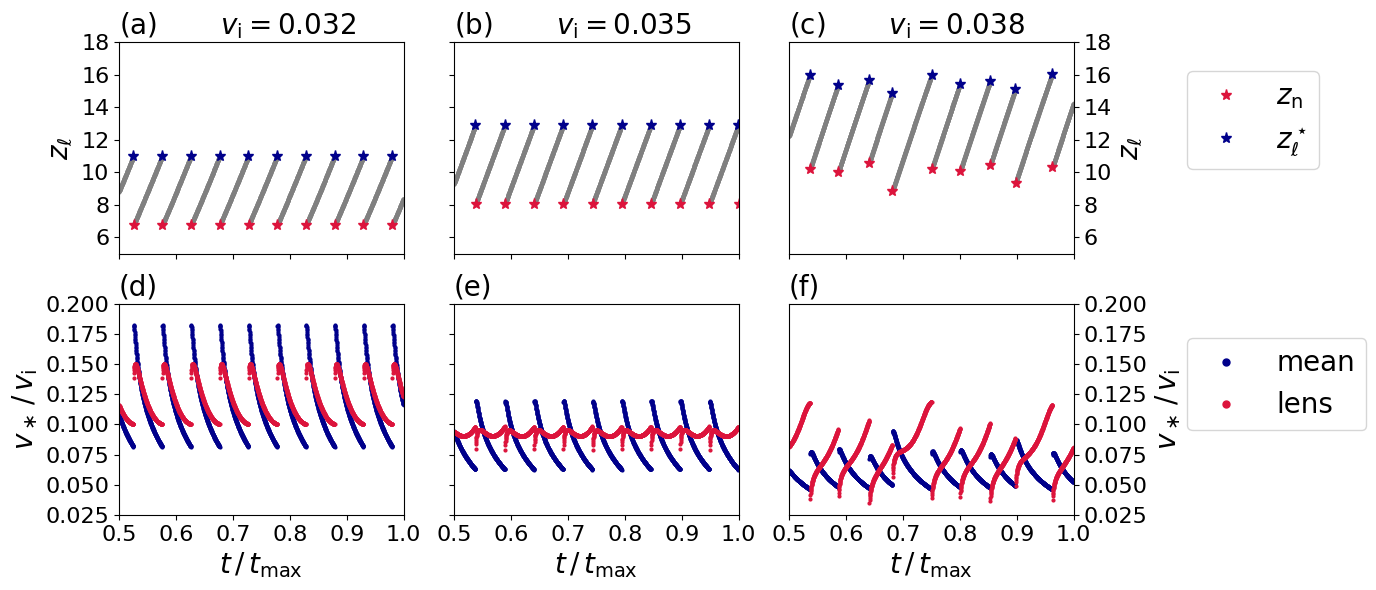

In [35]:
# plot position of active ice lens over time

plt.figure(figsize=(14,6))

plt.subplot(231)
plt.title(r'(a) $\qquad v_\mathrm{i}=0.032$',fontsize=20,loc='left')
z_l2 = np.max(z2,axis=1)
old_lens2 = np.roll(new_lens2,-1)
plt.plot(timesteps/timesteps.max(),z_l2,'o',markersize=2,color='gray')
plt.plot(timesteps[new_lens2==1]/timesteps.max(),z_l2[new_lens2==1],'*',markersize=8,color='crimson',label=r'$z_\mathrm{n}$')
plt.plot(timesteps[old_lens2==1]/timesteps.max(),z_l2[old_lens2==1],'*',markersize=8,color='darkblue',label=r'$z_\ell^\star$')
plt.ylabel(r'$z_\ell$',fontsize=20)
plt.yticks(fontsize=16)
plt.gca().xaxis.set_ticklabels([])
plt.xlim(0.5,1)
plt.ylim(5,18)

plt.subplot(234)
plt.title(r'(d)',fontsize=20,loc='left')

v_i = 0.032

heave_lens2 = heave2[:,-1] / v_i
heave_mean2 = np.mean(heave2,axis=1) / v_i

heave_min2 = 0*heave2[:,0]
val = 0
for i in range(heave_min2.size):
    heave_min2[i] = val
    if np.size(heave2[i,:][heave2[i,:]!=0])>0:
        val = np.min(heave2[i,:][heave2[i,:]!=0])
        heave_min2[i] = val

plt.plot(timesteps[heave_mean2!=0]/timesteps.max(),heave_mean2[heave_mean2!=0],'o',markersize=2,color='darkblue',label=r'mean')        
plt.plot(timesteps[heave_lens2!=0]/timesteps.max(),heave_lens2[heave_lens2!=0],'o',markersize=2,color='crimson',label=r'lens')
# plt.plot(timesteps[heave_min2!=0]/timesteps.max(),heave_min2[heave_min2!=0],'o',markersize=2,color='forestgreen',label=r'min')
plt.axhline(0,linewidth=1,linestyle='--',color='k')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'${v}_\ast \,/\,v_\mathrm{i}$',fontsize=20)
plt.xlim(0.5,1)
plt.ylim(0.025,0.2)
plt.xlabel(r'$t\,/\,t_\mathrm{max}$',fontsize=20)  
#---------------------------------------------------------

plt.subplot(232)
plt.title(r'(b) $\qquad v_\mathrm{i}=0.035$',fontsize=20,loc='left')
z_l3 = np.max(z3,axis=1)
old_lens3 = np.roll(new_lens3,-1)
plt.plot(timesteps/timesteps.max(),z_l3,'o',markersize=2,color='gray')
plt.plot(timesteps[new_lens3==1]/timesteps.max(),z_l3[new_lens3==1],'*',markersize=8,color='crimson',label=r'$z_\mathrm{n}$')
plt.plot(timesteps[old_lens3==1]/timesteps.max(),z_l3[old_lens3==1],'*',markersize=8,color='darkblue',label=r'$z_\ell^\star$')
plt.yticks(fontsize=16)
plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

plt.xlim(0.5,1)
plt.ylim(5,18)

plt.subplot(235)
plt.title(r'(e)',fontsize=20,loc='left')

v_i = 0.035

heave_lens3 = heave3[:,-1] / v_i
heave_mean3 = np.mean(heave3,axis=1) / v_i

heave_min3 = 0*heave3[:,0]
val = 0
for i in range(heave_min3.size):
    heave_min3[i] = val
    if np.size(heave3[i,:][heave3[i,:]!=0])>0:
        val = np.min(heave3[i,:][heave3[i,:]!=0])
        heave_min3[i] = val

plt.plot(timesteps[heave_mean3!=0]/timesteps.max(),heave_mean3[heave_mean3!=0],'o',markersize=2,color='darkblue',label=r'mean')
plt.plot(timesteps[heave_lens3!=0]/timesteps.max(),heave_lens3[heave_lens3!=0],'o',markersize=2,color='crimson',label=r'lens')
# plt.plot(timesteps[heave_min3!=0]/timesteps.max(),heave_min3[heave_min3!=0],'o',markersize=2,color='forestgreen',label=r'min')
plt.axhline(0,linewidth=1,linestyle='--',color='k')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.gca().yaxis.tick_right() 
plt.gca().yaxis.set_ticklabels([])
plt.xlim(0.5,1)
plt.ylim(0.025,0.2)
plt.xlabel(r'$t\,/\,t_\mathrm{max}$',fontsize=20)  




#---------------------------------------------------------
plt.subplot(233)
plt.title(r'(c) $\qquad v_\mathrm{i}=0.038$',fontsize=20,loc='left')
z_l = np.max(z,axis=1)
old_lens = np.roll(new_lens,-1)
plt.plot(timesteps/timesteps.max(),z_l,'o',markersize=2,color='gray')
plt.plot(timesteps[new_lens==1]/timesteps.max(),z_l[new_lens==1],'*',markersize=8,color='crimson',label=r'$z_\mathrm{n}$')
plt.plot(timesteps[old_lens==1]/timesteps.max(),z_l[old_lens==1],'*',markersize=8,color='darkblue',label=r'$z_\ell^\star$')

lgnd = plt.legend(fontsize=20,loc=(1.4,0.4),ncol=1)
lgnd.legendHandles[0].set_markersize(8)
lgnd.legendHandles[1].set_markersize(8)
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right() 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$z_\ell$',fontsize=20)
plt.ylim(5,18)
plt.gca().xaxis.set_ticklabels([])
plt.xlim(0.5,1)

plt.subplot(236)
plt.title(r'(f)',fontsize=20,loc='left')

v_i = 0.038


heave_lens = heave[:,-1] / v_i
heave_mean = np.mean(heave,axis=1) / v_i

heave_min = 0*heave[:,0]
val = 0
for i in range(heave_min.size):
    heave_min[i] = val
    if np.size(heave[i,:][heave[i,:]!=0])>0:
        val = np.min(heave[i,:][heave[i,:]!=0])
        heave_min[i] = val

plt.plot(timesteps[heave_mean!=0]/timesteps.max(),heave_mean[heave_mean!=0],'o',markersize=2,color='darkblue',label=r'mean')
plt.plot(timesteps[heave_lens!=0]/timesteps.max(),heave_lens[heave_lens!=0],'o',markersize=2,color='crimson',label=r'lens')
# plt.plot(timesteps[heave_min!=0]/timesteps.max(),heave_min[heave_min!=0],'o',markersize=2,color='forestgreen',label=r'min')
plt.axhline(0,linewidth=1,linestyle='--',color='k')
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'${v}_\ast \,/\,v_\mathrm{i}$',fontsize=20)
lgnd = plt.legend(fontsize=20,loc=(1.4,0.4),ncol=1)
lgnd.legendHandles[0].set_markersize(5)
lgnd.legendHandles[1].set_markersize(5)
plt.xlim(0.5,1)
plt.ylim(0.025,0.2)
plt.xlabel(r'$t\,/\,t_\mathrm{max}$',fontsize=20)  
plt.tight_layout()
plt.savefig('examples')
plt.show()
plt.close()